In [ ]:
!pip3 install torch numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [1]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/FIT5217/Assignment2/Cooking_Dataset

/content/drive/MyDrive/FIT5217/Assignment2/Cooking_Dataset


In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# **Implementation of Baseline 1**

---

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),torch.zeros(1, 1, self.hidden_size, device=device))

In [6]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([;])", r",", s)
    s = re.sub(r"[\W]+", r" ", s)
    return s

In [8]:
def readLangs(ingredients, recipe):
    print("Reading lines...")

    ingredients = [str(s) for s in ingredients]
    recipe = [str(s) for s in recipe]
    ingredients = [normalizeString(str(s)) for s in ingredients]
    recipe = [normalizeString(str(s)) for s in recipe]

    pairs = [[ingredients[i],recipe[i]] for i in range(len(ingredients))]

    input_lang = Lang('Ingredients')
    output_lang = Lang('Recipe')

    return input_lang, output_lang, pairs

In [9]:
MAX_LENGTH = 150


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
dev = pd.read_csv("dev.csv")
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s ingredients to recipe pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData(train.Ingredients, train.Recipe)
print(random.choice(pairs))

Reading lines...
Read 101340 ingredients to recipe pairs
Trimmed to 85857 sentence pairs
Counting words...
Counted words:
Ingredients 15154
Recipe 29059
['1 dried ancho chile 1 ounce 1 1 2 oz sun dried tomatoes 20 packed without oil 2 c boiling water 1 tb olive oil 1 4 c minced red onion 1 garlic minced 3 c fresh corn kernels 2 c diced zucchini 1 4 c tequila 1 tb minced fresh tarragon 1 2 ts salt 1 pork tenderloin 1 pound 3 4 ts ground cumin 1 2 ts salt 1 2 ts pepper vegetable cooking spray 8 c torn romaine lettuce', 'remove stem and seeds from chile combine chile tomatoes and boiling wate r cover and let stand 20 minutes drain reserving 1 4 cup liquid chop chile and tomatoes set aside heat oil in a large nonstick skillet over medium heat add onion and garlic saute 1 minute add reserved 1 4 cup liquid corn zucchini and tequila cook 7 minutes or until vegetables are tender and liquid nearly evaporates spoon into a bowl stir in chopped chile chopped tomato tarragon and 1 2 teaspoon salt 

In [ ]:
input_test, output_test, pairs_test = prepareData(test.Ingredients, test.Recipe)
input_dev, output_dev, pairs_dev = prepareData(dev.Ingredients, dev.Recipe)
print(random.choice(pairs_test))
print(random.choice(pairs_dev))

Reading lines...
Read 778 ingredients to recipe pairs
Trimmed to 676 sentence pairs
Counting words...
Counted words:
Ingredients 1859
Recipe 3065
Reading lines...
Read 797 ingredients to recipe pairs
Trimmed to 682 sentence pairs
Counting words...
Counted words:
Ingredients 1851
Recipe 3231
['3 4 lb tuna steak 1 2 c lime juice 1 2 c 4 ounces coconut milk 2 tb olive oil salt and pepper 1 c small diced mango 2 tb small diced red pepper 2 tb chopped fresh cilantro 2 tb toasted coconut 2 tb minced shallots cilantro sprigs for garnish', 'dice the tuna into small pieces place in a glass bowl cover with the lime juice and coconut milk cover and refrigerate for 4 hours pour off the excess liquid and toss with 1 tablespoon of the olive oil and salt and pepper to taste in another bowl combine the mango peppers cilantro shallots coconut and the remaining olive oil and season combine remaining ingredients for relish begin building your parfait place 1 tablespoon of the relish in the bottom of each

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')  if word in lang.word2index]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [12]:
teacher_forcing_ratio = 1
MAX_LENGTH = 150

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters())
    decoder_optimizer = optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    losses_val = []
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            loss_avg_val = evaluate_val(encoder, decoder, pairs_dev)
            losses_val.append(loss_avg_val)
            print('%s (%d %d%%) Train Loss: %.4f Val Loss: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, loss_avg_val))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses, losses_val)

In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points_train, points_val):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points_train)
    plt.plot(points_val)

In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [17]:
def evaluate_val(encoder, decoder, pairs_dev, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    criterion = nn.NLLLoss()
    val_loss_total = 0
    with torch.no_grad():
      for pair in pairs_dev:
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        loss = 0

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
        val_loss_total += loss.item()/target_length
      encoder.train()
      decoder.train()
      return val_loss_total/len(pairs_dev)

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 10000, print_every=100)

In [ ]:
torch.save(encoder1.state_dict(),"encoder_baseline1.pt")
torch.save(decoder1.state_dict(),"decoder_baseline1.pt")

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
encoder1.load_state_dict(torch.load("encoder_baseline1.pt",device))
print(encoder1.eval())
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)
decoder1.load_state_dict(torch.load("decoder_baseline1.pt",device))
print(decoder1.eval())

EncoderRNN(
  (embedding): Embedding(15154, 256)
  (lstm): LSTM(256, 256)
)
DecoderRNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (embedding): Embedding(29059, 256)
  (lstm): LSTM(256, 256)
  (out): Linear(in_features=256, out_features=29059, bias=True)
  (softmax): LogSoftmax(dim=1)
)


# **Implementation of Baseline 2**

---

In [19]:
MAX_LENGTH = 150
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0].view(1,-1)), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device))

In [20]:
teacher_forcing_ratio = 1


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [21]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [22]:
def evaluate_val_attn(encoder, decoder, pairs_dev, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    criterion = nn.NLLLoss()
    val_loss_total = 0
    with torch.no_grad():
      for pair in pairs_dev:
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        loss = 0
        decoder_attentions = torch.zeros(max_length, max_length)
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
        val_loss_total += loss.item()/target_length
      encoder.train()
      decoder.train()
      return val_loss_total/len(pairs_dev)

In [23]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters())
    decoder_optimizer = optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    losses_val = []
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            loss_avg_val = evaluate_val_attn(encoder, decoder, pairs_dev)
            losses_val.append(loss_avg_val)
            print('%s (%d %d%%) Train Loss: %.4f Val Loss: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, loss_avg_val))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses,losses_val)


1m 24s (- 139m 27s) (100 1%) Train Loss: 7.3001 Val Loss: 6.6600
2m 40s (- 131m 15s) (200 2%) Train Loss: 6.5311 Val Loss: 6.5148
3m 56s (- 127m 25s) (300 3%) Train Loss: 6.3845 Val Loss: 6.4688
5m 11s (- 124m 35s) (400 4%) Train Loss: 6.2978 Val Loss: 6.4439
6m 23s (- 121m 33s) (500 5%) Train Loss: 6.2787 Val Loss: 6.3791
7m 39s (- 119m 58s) (600 6%) Train Loss: 6.1472 Val Loss: 6.3959
8m 55s (- 118m 35s) (700 7%) Train Loss: 5.7664 Val Loss: 6.5187
10m 10s (- 116m 56s) (800 8%) Train Loss: 5.6841 Val Loss: 6.4691
11m 26s (- 115m 42s) (900 9%) Train Loss: 5.7517 Val Loss: 6.5107
12m 41s (- 114m 13s) (1000 10%) Train Loss: 5.4068 Val Loss: 6.5807
13m 56s (- 112m 48s) (1100 11%) Train Loss: 5.2168 Val Loss: 6.5732
15m 10s (- 111m 18s) (1200 12%) Train Loss: 5.3715 Val Loss: 6.5685
16m 25s (- 109m 57s) (1300 13%) Train Loss: 5.2129 Val Loss: 6.5731
17m 40s (- 108m 34s) (1400 14%) Train Loss: 5.1921 Val Loss: 6.6558
18m 53s (- 107m 0s) (1500 15%) Train Loss: 5.1732 Val Loss: 6.5939
20m 8s

<Figure size 640x480 with 0 Axes>

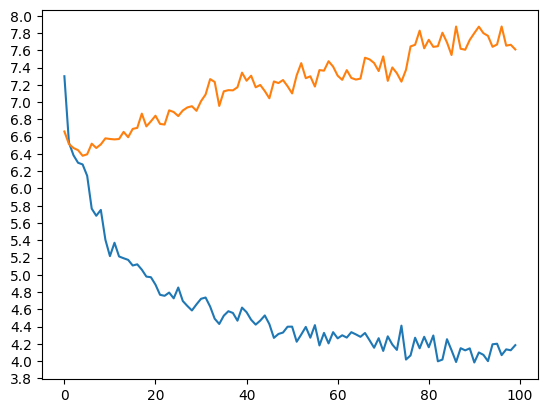

In [ ]:
hidden_size = 256
attn_encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters_attn(attn_encoder1, attn_decoder1, 10000, print_every=100)

torch.save(attn_encoder1.state_dict(),"encoder_baseline2.pt")
torch.save(attn_decoder1.state_dict(),"decoder_baseline2.pt")

In [24]:
hidden_size = 256
attn_encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_encoder1.load_state_dict(torch.load("encoder_baseline2.pt",device))
print(attn_encoder1.eval())
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)
attn_decoder1.load_state_dict(torch.load("decoder_baseline2.pt",device))
print(attn_decoder1.eval())

EncoderRNN(
  (embedding): Embedding(15154, 256)
  (lstm): LSTM(256, 256)
)
AttnDecoderRNN(
  (embedding): Embedding(29059, 256)
  (attn): Linear(in_features=512, out_features=150, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(256, 256)
  (out): Linear(in_features=256, out_features=29059, bias=True)
)


# **Implementation of Extension 1**

---



In [25]:
import nltk
# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [26]:

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def normalizeStringIngredients(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r'\b[a-zA-Z]{1,2}\b', " ", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s = re.sub(r"[\s]+", r" ", s)
    words = nltk.word_tokenize(s)
    # Tag the words with part-of-speech tags
    tagged_words = nltk.pos_tag(words)
    # Keep only words that are tagged as NN (noun, singular)
    nouns = [word for word, tag in tagged_words if tag == 'NN']
    nouns.sort()
    nouns = list(dict.fromkeys(nouns))
    # Join the nouns back into a string
    s = ' '.join(nouns)
    return s
def normalizeStringRecipe(s):
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([;])", r".", s)
    s = re.sub(r"[^a-zA-Z0-9]+", r" ", s)
    #s = re.sub(r"[^a-zA-Z0-9\.,]+", r" ", s)
    s = re.sub(r"[\s]+", r" ", s)
    return s

In [27]:
def readLangs(ingredients, recipe):
    print("Reading lines...")

    ingredients = [str(s) for s in ingredients]
    recipe = [str(s) for s in recipe]
    ingredients = [normalizeStringIngredients(str(s)) for s in ingredients]
    recipe = [normalizeStringRecipe(str(s)) for s in recipe]
    pairs = [[ingredients[i],recipe[i]] for i in range(len(ingredients))]
    input_lang = Lang('Ingredients')
    output_lang = Lang('Recipe')

    return input_lang, output_lang, pairs

In [28]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')  if word in lang.word2index]


def tensorFromSentence(lang, sentence, ingredients = False):
    indexes = indexesFromSentence(lang, sentence)
    if ingredients:
      indexes = list(set(indexes))
      indexes.sort()
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0], True)
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [29]:
MAX_LENGTH = 150


def filterPair(p):
    return ((1 <= len(p[0].split(' ')) < MAX_LENGTH) and \
        (2 < len(p[1].split(' ')) < MAX_LENGTH) and \
        (len(p[1].split('.')) < 15))


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
def removeDuplicates(pairs):
  pair_list = {pair[0]: pair for pair in pairs}
  return list(pair_list.values())

In [34]:
import pandas as pd
train = pd.read_csv("train.csv").drop_duplicates(subset='Ingredients', keep="first")
test = pd.read_csv("test.csv")
dev = pd.read_csv("dev.csv").drop_duplicates(subset='Ingredients', keep="first")
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s ingredients to recipe pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    pairs = removeDuplicates(pairs)
    print("Trimmed further to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData(train.Ingredients, train.Recipe)
print(random.choice(pairs))

Reading lines...
Read 91263 ingredients to recipe pairs
Trimmed to 77458 sentence pairs
Trimmed further to 69515 sentence pairs
Counting words...
Counted words:
Ingredients 7987
Recipe 27697
['chicken ground mild pork pref shoulder', 'melt the pork fat in a heavy skillet over medium high heat add the pork cubes a few at a time stirring to brown evenly add the salt and garlic stirring well remove from the heat and stir in the ground chile and oregano coating the meat evenly with the spices rrb add a small amount of broth and stir well return to the heat add a bit more broth and stir continue to add broth a little at a time stirring until the chili is smooth then reduce the heat and simmer uncovered for about 1 hour taste and adjust seasonings adding the ground hot chile to taste at this point to add remove the pot from the heat sprinkle the chile over the top and stir well serve the chili with a bowl of freshly stewed pinto beans on the side ']


In [31]:
input_dev, output_dev, pairs_dev = prepareData(dev.Ingredients, dev.Recipe)
ingredients = [normalizeStringIngredients(str(s)) for s in test.Ingredients]
print(random.choice(pairs_dev))

Reading lines...
Read 793 ingredients to recipe pairs
Trimmed to 679 sentence pairs
Counting words...
Counted words:
Ingredients 872
Recipe 3184
['anise chicken cinnamon dark oil rice sesame sherry soy star stick sugar wine', 'bring them to a slow boil in a large kettle add meat or poultry return to slow boil reduce heat to simmer and cook until done drain meat and serve with some sauce lrb optionally thickened with cornstarch water rrb on the side save and reuse leftover sauce which gets richer with each use ']


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),torch.zeros(1, 1, self.hidden_size, device=device))

In [ ]:
MAX_LENGTH = 150
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0].view(1,-1)), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device))

In [ ]:
teacher_forcing_ratio = 1


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [ ]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters())
    decoder_optimizer = optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    losses_val = []
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            loss_avg_val = evaluate_val_attn(encoder, decoder, pairs_dev)
            losses_val.append(loss_avg_val)
            print('%s (%d %d%%) Train Loss: %.4f Val Loss: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, loss_avg_val))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses,losses_val)


In [ ]:
def evaluate_val_attn(encoder, decoder, pairs_dev, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    criterion = nn.NLLLoss()
    val_loss_total = 0
    with torch.no_grad():
      for pair in pairs_dev:
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        loss = 0
        decoder_attentions = torch.zeros(max_length, max_length)
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
        val_loss_total += loss.item()/target_length
      encoder.train()
      decoder.train()
      return val_loss_total/len(pairs_dev)

In [ ]:
hidden_size = 256
attn_encoder1_1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1_1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters_attn(attn_encoder1_1, attn_decoder1_1, 10000, print_every=100)

1m 6s (- 110m 4s) (100 1%) Train Loss: 7.2752 Val Loss: 6.5613
2m 12s (- 108m 19s) (200 2%) Train Loss: 6.2857 Val Loss: 6.5689
3m 19s (- 107m 20s) (300 3%) Train Loss: 6.0586 Val Loss: 6.6044
4m 22s (- 105m 11s) (400 4%) Train Loss: 5.8290 Val Loss: 6.7002
5m 28s (- 103m 54s) (500 5%) Train Loss: 5.7340 Val Loss: 6.7462
6m 33s (- 102m 51s) (600 6%) Train Loss: 5.3995 Val Loss: 6.8530
7m 39s (- 101m 39s) (700 7%) Train Loss: 5.3304 Val Loss: 6.9600
8m 44s (- 100m 28s) (800 8%) Train Loss: 5.3046 Val Loss: 7.0560
9m 49s (- 99m 19s) (900 9%) Train Loss: 5.1166 Val Loss: 7.0687
10m 54s (- 98m 6s) (1000 10%) Train Loss: 5.1842 Val Loss: 7.1094
11m 58s (- 96m 49s) (1100 11%) Train Loss: 4.9143 Val Loss: 7.1690
13m 2s (- 95m 40s) (1200 12%) Train Loss: 5.2300 Val Loss: 7.2124
14m 7s (- 94m 35s) (1300 13%) Train Loss: 4.9153 Val Loss: 7.2577
15m 15s (- 93m 40s) (1400 14%) Train Loss: 5.0950 Val Loss: 7.2263
16m 19s (- 92m 29s) (1500 15%) Train Loss: 4.7515 Val Loss: 7.3689
17m 25s (- 91m 27s)

In [ ]:
torch.save(attn_encoder1_1.state_dict(),"encoder_extended1.pt")
torch.save(attn_decoder1_1.state_dict(),"decoder_extended1.pt")

In [ ]:
hidden_size = 256
attn_encoder1_1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_encoder1_1.load_state_dict(torch.load("encoder_extended1.pt",device))
print(attn_encoder1_1.eval())
attn_decoder1_1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)
attn_decoder1_1.load_state_dict(torch.load("decoder_extended1.pt",device))
print(attn_decoder1_1.eval())

In [37]:
predictions_0 = [' '.join(evaluate(encoder1,decoder1,s,MAX_LENGTH)) for s in ingredients]
predictions_00 = [' '.join(evaluate_attn(attn_encoder1,attn_decoder1,s,MAX_LENGTH)[0]) for s in ingredients]
predictions_1 = [' '.join(evaluate_attn(attn_encoder1_1,attn_decoder1_1,s,MAX_LENGTH)[0]) for s in ingredients]

# **Implementation of Extension 2**


In [38]:
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained Word2Vec model
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [39]:
# Helper function to get pre-trained word embeddings
def get_pretrained_embedding(word, model, embedding_dim=300):
    if word in model.key_to_index:
        return torch.tensor(model[word], dtype=torch.float).to(device)
    else:
        return torch.zeros(embedding_dim, dtype=torch.float).to(device)

In [40]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, pre_trained_model, embedding_dim=300):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialize embedding weights with pre-trained embeddings
        self.embedding.weight.data.copy_(self.load_pretrained_embeddings(pre_trained_model, input_size, hidden_size))
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def load_pretrained_embeddings(self, pre_trained_model, input_size, hidden_size):
        embeddings = torch.zeros(input_size, hidden_size)
        for idx in range(input_size):
            word = input_lang.index2word[idx]  # idx2word should map index to word
            embeddings[idx] = get_pretrained_embedding(word, pre_trained_model, hidden_size)
        return embeddings

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))


In [41]:
MAX_LENGTH = 150

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, pre_trained_model, dropout_p=0.1, max_length=MAX_LENGTH, embedding_dim=300):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # Initialize embedding weights with pre-trained embeddings
        self.embedding.weight.data.copy_(self.load_pretrained_embeddings(pre_trained_model, output_size, hidden_size))
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def load_pretrained_embeddings(self, pre_trained_model, output_size, hidden_size):
        embeddings = torch.zeros(output_size, hidden_size)
        for idx in range(output_size):
            word = output_lang.index2word[idx]
            embeddings[idx] = get_pretrained_embedding(word, pre_trained_model, hidden_size)
        return embeddings

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0].view(1,-1)), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device))

1m 12s (- 120m 19s) (100 1%) Train Loss: 7.2649 Val Loss: 6.6552
2m 20s (- 115m 6s) (200 2%) Train Loss: 6.4589 Val Loss: 6.4540
3m 34s (- 115m 33s) (300 3%) Train Loss: 6.3694 Val Loss: 6.3400
4m 44s (- 113m 39s) (400 4%) Train Loss: 6.2623 Val Loss: 6.3296
5m 53s (- 111m 53s) (500 5%) Train Loss: 6.3363 Val Loss: 6.3020
7m 1s (- 110m 7s) (600 6%) Train Loss: 6.1884 Val Loss: 6.3629
8m 9s (- 108m 25s) (700 7%) Train Loss: 6.0874 Val Loss: 6.4898
9m 17s (- 106m 53s) (800 8%) Train Loss: 5.9268 Val Loss: 6.4509
10m 25s (- 105m 24s) (900 9%) Train Loss: 5.6686 Val Loss: 6.6783
11m 35s (- 104m 18s) (1000 10%) Train Loss: 5.5926 Val Loss: 6.7331
12m 45s (- 103m 13s) (1100 11%) Train Loss: 5.6079 Val Loss: 6.9026
13m 54s (- 102m 3s) (1200 12%) Train Loss: 5.4426 Val Loss: 6.8979
15m 3s (- 100m 47s) (1300 13%) Train Loss: 5.3186 Val Loss: 6.8408
16m 12s (- 99m 36s) (1400 14%) Train Loss: 5.1965 Val Loss: 6.9149
17m 24s (- 98m 40s) (1500 15%) Train Loss: 4.9635 Val Loss: 6.9287
18m 36s (- 97m

<Figure size 640x480 with 0 Axes>

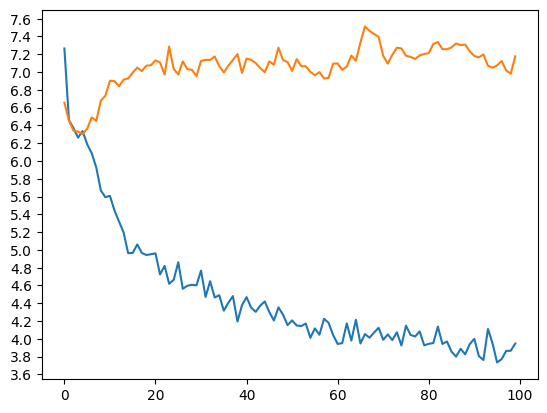

In [ ]:
hidden_size = 300
attn_encoder2 = EncoderRNN(input_lang.n_words, hidden_size,model).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, model, dropout_p=0.1).to(device)

trainIters_attn(attn_encoder2, attn_decoder2, 10000, print_every=100)

In [ ]:
torch.save(attn_encoder2.state_dict(),"encoder_extended2.pt")
torch.save(attn_decoder2.state_dict(),"decoder_extended2.pt")

In [ ]:
hidden_size = 300
attn_encoder2 = EncoderRNN(input_lang.n_words, hidden_size, model)
attn_encoder2.load_state_dict(torch.load("encoder_extended2.pt",device))
print(attn_encoder2.eval())
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, model, dropout_p=0.1)
attn_decoder2.load_state_dict(torch.load("decoder_extended2.pt",device))
print(attn_decoder2.eval())

In [ ]:
predictions_2 = [' '.join(evaluate_attn(attn_encoder2,attn_decoder2,s,MAX_LENGTH)[0]) for s in ingredients]

In [48]:
def remove_last_word(string):
    words = string.split()
    return ' '.join(words[:-1])

# Apply the function to each string in the list to remove the <EOS> taag
predictions_0 = [remove_last_word(s) for s in predictions_0]
predictions_00 = [remove_last_word(s) for s in predictions_00]
predictions_1 = [remove_last_word(s) for s in predictions_01]
predictions_2 = [remove_last_word(s) for s in predictions_2]

# Evaluations, metrics and generating the final csv file

In [49]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate import meteor_score
gold = "combine <sugar> and <water> in medium saucepan . Heat , stirring , until <sugar> dissolves , then boil 5 minutes . cool . force <strawberries> through food mill or blend in blender or food processor . strain to remove seeds , if desired . blend the puree and <lemon juice> and <orange juice> into syrup . pour into freezer trays and freeze . remove from freezer 20 minutes before serving . turn into bowl and stir until smooth .".split()
sample = "Combine <sugar> and <water> in a medium saucepan . Heat, stirring, until <sugar> dissolves . Bring to a boil and let simmer for 5 minutes . Remove from heat and allow to cool . In a blender or food processor , combine <strawberries> and <cantaloupe> . Blend until smooth . Strain the mixture to remove any seeds and fibers, if desired. Stir the puree into the cooled syrup along with the <lemon juice> and <orange juice> . Pour the mixture into a large bowl and gently fold in the <vanilla ice cream> until well mixed . Freeze in a container for at least 4 hours . Before serving , let it sit at room temperature for 20 minutes to soften . Stir well to achieve a smooth consistency and serve chilled .".split()

In [50]:
sentence_bleu([gold], sample)

0.11770400167201682

In [51]:
nltk.download('wordnet')
meteor_score.meteor_score([gold], sample)

[nltk_data] Downloading package wordnet to /root/nltk_data...


0.5736654804270463

In [ ]:
sum([sentence_bleu([test.Recipe[i].split()], predictions_2[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [ ]:
sum([sentence_bleu([test.Recipe[i].split()], predictions_1[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [ ]:
sum([meteor_score.meteor_score([test.Recipe[i].split()], predictions_1[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [ ]:
sum([meteor_score.meteor_score([test.Recipe[i].split()], predictions_2[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [52]:
def extra(truth,pred):
  return sum([1 for w in pred if w not in truth])

In [ ]:
sum([extra(test.Recipe[i].split(), predictions_1[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [ ]:
sum([extra(test.Recipe[i].split(), predictions_2[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [53]:
def given(truth,pred):
  return sum([1 for w in truth if w in pred])/len(truth)
sum([given(test.Recipe[i].split(), predictions_1[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [ ]:
sum([given(test.Recipe[i].split(), predictions_2[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

In [54]:
extra(gold,sample)

60

In [55]:
given(gold,sample)

0.7721518987341772

In [56]:
sum([given(test.Recipe[i].split(), predictions_0[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

0.185015224178579

In [57]:
sum([given(test.Recipe[i].split(), predictions_00[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

0.15759055848775372

In [58]:
sum([extra(test.Recipe[i].split(), predictions_0[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

19.533419023136247

In [59]:
sum([extra(test.Recipe[i].split(), predictions_00[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

12.222365038560412

In [60]:
sum([sentence_bleu([test.Recipe[i].split()], predictions_0[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

0.0032338780771845816

In [61]:
sum([sentence_bleu([test.Recipe[i].split()], predictions_00[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

0.0006401527443015746

In [62]:
sum([meteor_score.meteor_score([test.Recipe[i].split()], predictions_0[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

0.082428071303489

In [63]:
sum([meteor_score.meteor_score([test.Recipe[i].split()], predictions_00[i].split()) for i in range(len(test.Recipe))])/len(test.Recipe)

0.0575463662417303

In [66]:
print(min(len(pair[0].split(' ')) for pair in pairs))

1


In [65]:
print(min(len(pair[1].split(' ')) for pair in pairs))

3


In [ ]:
generated_33197970 = test.iloc[:, :-1]
generated_33197970['Generated Recipe - Baseline 1'] = predictions_0
generated_33197970['Generated Recipe - Baseline 2'] = predictions_00
generated_33197970['Generated Recipe - Extended 1'] = predictions_1
generated_33197970['Generated Recipe - Extended 2'] = predictions_2

In [ ]:
generated_33197970.to_csv('generated_33197970.csv', index=False)